In [1]:
#Load packages and set options
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)

options(repr.matrix.max.rows = 8)
options(repr.plot.width = 8, repr.plot.height = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading data set from the web
url <- "https://raw.githubusercontent.com/trungnguyen21/group_project_dsci/main/data/rice_data.csv"
rice_data <- read_csv(url)

New names:
• `` -> `...1`
Rows: 3810 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (8): ...1, Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Eccent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Cleaning data set: cleaning names, renaming class and changing to factor, and removing first column
rice <- rice_data |>
  clean_names() |>
  mutate(class = as_factor(class),
         class = fct_recode(class, "Cammeo" = "b'Cammeo'", "Osmancik" = "b'Osmancik'")) |>
  select(-x1)
rice

area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
13176,458.343,193.3374,87.44839,0.8918609,13368,0.6406690,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11625,421.390,167.7148,89.46257,0.8458499,11904,0.6942785,Osmancik
12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,Osmancik
9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,Osmancik
11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


In [4]:
#Splitting data set into training and testing data sets
rice_split <- initial_split(rice, prop = 0.75, strata = class)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

In [5]:
#Summary table: means of each predictor, missing data count, and number of observations
rice_train_summary <- rice_train |>
  mutate(na_count = rowSums(is.na(rice_train))) |>
  group_by(class) |>
  summarize(across(area:na_count, mean, na.rm = TRUE), obs = n())
rice_train_summary

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(area:na_count, mean, na.rm = TRUE)`.
ℹ In group 1: `class = Cammeo`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


class,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,na_count,obs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Cammeo,14162.47,487.3063,205.4147,88.78420,0.9009714,14493.09,0.6499055,0,1222
Osmancik,11547.36,429.4257,176.2616,84.47679,0.8762242,11797.50,0.6698278,0,1635


class,predictor,value
<fct>,<chr>,<dbl>
Cammeo,area,14634.00000
Cammeo,perimeter,501.12201
Cammeo,major_axis_length,214.10678
Cammeo,minor_axis_length,87.76829
⋮,⋮,⋮
Osmancik,minor_axis_length,7.821048e+01
Osmancik,eccentricity,8.744061e-01
Osmancik,convex_area,1.009700e+04
Osmancik,extent,6.590636e-01


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


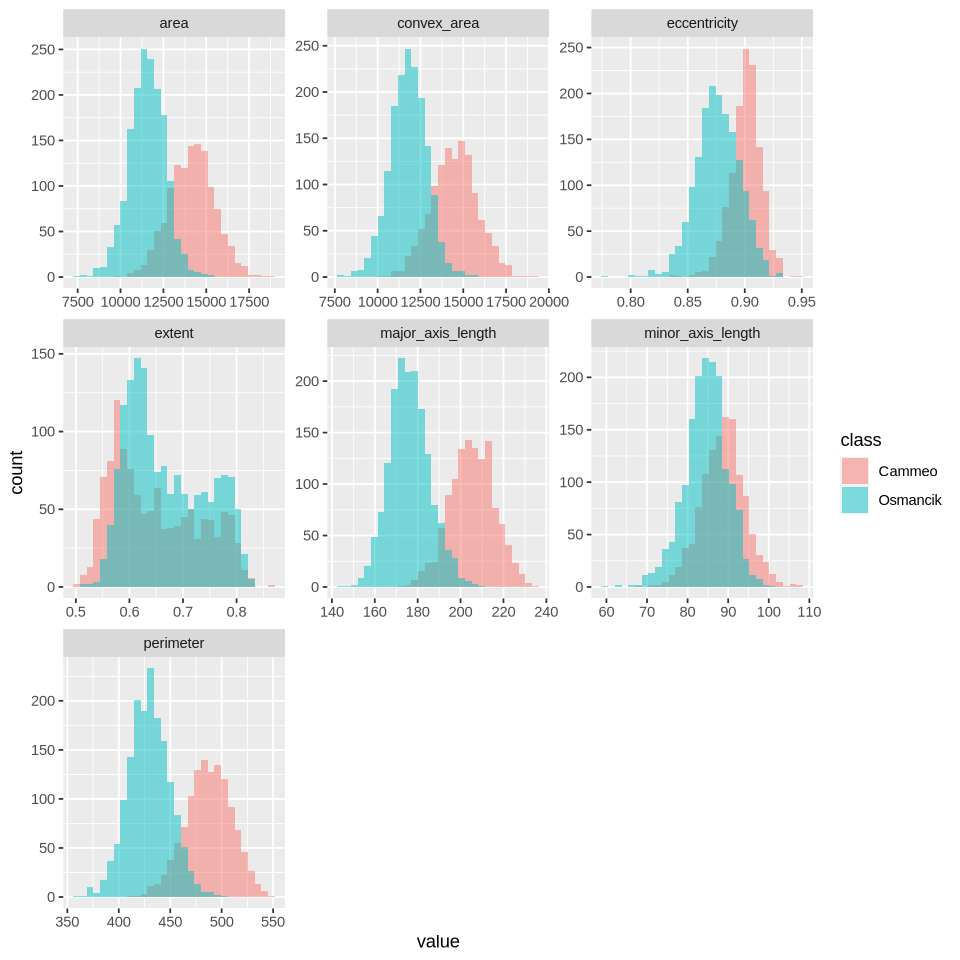

In [6]:
#Pivot long rice training set and create histograms for all predictors
rice_train_long <- rice_train |>
  pivot_longer(cols = area:extent, names_to = "predictor", values_to = "value")
rice_train_long

rice_hist <- rice_train_long |>
  ggplot(aes(x = value, fill = class)) +
  geom_histogram(alpha = 0.5, position = "identity") +
  facet_wrap(~predictor, scales = "free")
rice_hist